# Unidad 2 - 02 Laboratorio de Regresión Lineal

---



Basamos este laboratorio en datos obtenidos de Kaggle https://www.kaggle.com/code/sudhirnl7/linear-regression-tutorial/data*

De allí tomamos un dataset con el objetivo de construir un método de regresión lineal para la predicción de la cuota de seguro médico en función de algunas características del cliente. Las características informadas serán: edad, sexo, BMI, cantidad de hijos, su condición de fumador/no fumador y región.

Esos datos serán los identificados como **features**. La **etiqueta** (label) será el costo de la cuota del seguro médico.

La intención es reconstruir los pasos de la regresión lineal y comparar con lo que ya está programado en Scikit-Learn para entender el funcionamiento del método.



Importamos primero las librerías de Python y cargamos el conjuto de datos.


In [ ]:
import pandas  as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('/content/drive/MyDrive/MyML/TMAA/Clases/insurance.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print('\nCantidad de filas y columnas del dataframe: ',df.shape)
print('')
print("Miremos las primeras columnas:\n ")
df.head()


Cantidad de filas y columnas del dataframe:  (1338, 7)

Miremos las primeras columnas:
 


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Observamos que:

* Las columnas 1 a 6 son **features** y que la columna **label** es la columna de "charges"

* Hay varias columnas con datos "categóricos"

* La feature "children" debe ser entendida como variable categórica aún cuando la entrada sea un número entero.


Aunque no nos dediquemos a hacer "exploración de datos (EDA)" podemos mirar rápidamente algo de la información estadística que pandas nos regala, a partir del dataset.

In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


La tarea de limpiar el dataset viene ahora. En términos generales es un buen data set ya que: no posee "missing values" ni se evidencia correlación entre las variables.

En primer lugar nos toca la tarea de decidir cómo manejar los datos que se presentan de manera categórica, los cuales no son utilizables para un modelo matemático como el que intentamos construir. La respuesta aquí es: **ENCODING**

**ENCODING**

La tarea de transformar los datos no numéricos en datos numéricos puede encararse de diversas maneras: **Label enconding**, **One hot encoding**, entre otras.

Utilizaremos la última mencionada.

Esta estrategia consiste en crear una columna binaria (que solo puede contener los valores 0 o 1) para cada valor único que exista en la variable categórica que estamos codificando, y marcar con un 1 la columna correspondiente al valor presente en cada registro, dejando las demás columnas con un valor de 0. Por ejemplo, en el caso de la variable "sex" de los pasajeros del Titanic, One Hot Encoding crearía dos columnas binarias (una para el valor "male" y otra para el valor "female"). Para cada pasajero, se asignaría un valor de 1 a la columna correspondiente a su género y un valor de 0 a la columna del género opuesto. De esta manera, cada registro queda representado por un vector binario que indica la presencia o ausencia de cada valor categórico, y se evita la posibilidad de que los algoritmos malinterpreten los valores numéricos asignados por Label Encoding.


Por ejemplo, si codificamos cuatro ciudades con los valores 0, 1, 2 y 3, es posible que un algoritmo interprete erróneamente que, por ejemplo, la ciudad correspondiente al valor 3 tiene -según algún criterio- un valor tres veces mayor que la ciudad con el valor 1, lo cual no es cierto.

Por otro lado, este es el momento de observar si existen 2 o mas variables altamente correlacionadas, en el sentido que alguna de ellas puede predirse a partir de otras. En el caso de que así fuera, necesitamos dejarlas fuera del análisis. Esto se conoce como **dummy variable tap** (trampa de variables ficticias).

Pandas, sabe hacer ésto de manera muy efectiva a través de las funciones: get_dummies y drop_first.

In [ ]:
# Enlistamos las variables categóricas que queremos que el modelo observe
categorical_columns = ['sex','children', 'smoker', 'region']
# Definimos un nuevo dataframe de pandas "encodeado" a partir de aplicar la función get_dummies al dataframe original.
df_encode = pd.get_dummies(data = df, prefix = 'OHE', prefix_sep='_',  # Se fijan los prefijos para los nombres de las nuevas columnas
               columns = categorical_columns,     # le decimos al modelo cuáles son las columnas categóricas
               drop_first =True,  # descartamos (si hubiera) variables correlacionadas
              dtype='int8')  # declaramos el tipo de daro que queremos en nuestras nuevas columnas

In [ ]:
# Analizamos el resultado del proceso anterior

print('Columnas en el dataframe original:\n',df.columns.values)
print('\nCantidad de filas y columnas en el dataframe:',df.shape)
print('\nColumnas en el dataframe luego de codificar las dummy variables:\n',df_encode.columns.values)
print('\nCantidad de filas y columnas en el dataframe:',df_encode.shape)

Columnas en el dataframe original:
 ['age' 'sex' 'bmi' 'children' 'smoker' 'region' 'charges']

Cantidad de filas y columnas en el dataframe: (1338, 7)

Columnas en el dataframe luego de codificar las dummy variables:
 ['age' 'bmi' 'charges' 'OHE_male' 'OHE_1' 'OHE_2' 'OHE_3' 'OHE_4' 'OHE_5'
 'OHE_yes' 'OHE_northwest' 'OHE_southeast' 'OHE_southwest']

Cantidad de filas y columnas en el dataframe: (1338, 13)


Obsevamos que ahora tenemos 13 columnas en lugar de 7, pero no hemos "perdido" ninguna.

* La columna "sex" es ahora una columna de 0 y 1 (para male).

* La columna de "children" se transformó en 5 columnas con un 1 en la columna que indique la cantidad correcta.

* La columna "smoker" es ahora una columna de 0 y 1 (para fumador).

* La columna "region" se transformó en 3 columnas de 0 y 1 con un 1 en la columna que indique la región declarada.

In [ ]:
sns.histplot?

QUÉ SIGUE?

Si hiciéramos el EDA, obtendríamos en este caso que la columna "charges", posee valores que no están normalmente distribuidos:




<Axes: xlabel='charges', ylabel='Count'>

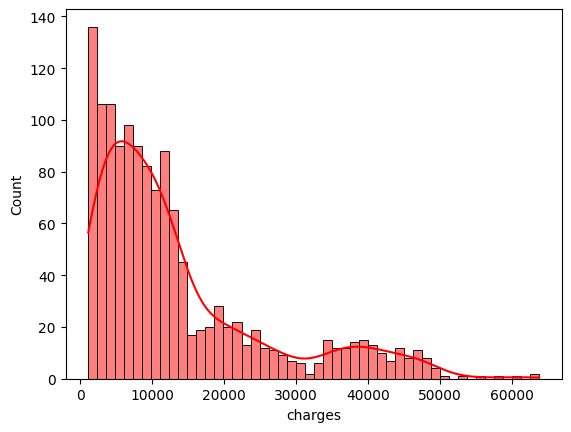

In [ ]:
sns.histplot(df['charges'],bins=50,color='r', kde=True,)

 Para "hacer que sean normales" aplicamos una técnica estadística: transformación box-cox, con la ayuda de Scipy.

In [ ]:
from scipy.stats import boxcox
y_bc,lam, ci= boxcox(df_encode['charges'],alpha=0.05)
# df_encode['charges'] = y_bc

In [ ]:
boxcox?

Vemos que boxcox devuelve:
- un array correspondiente al array encodeado (en nuestro caso la columna charges del dataframe), que la guardamos en la variable y_bc,
- un valor lambda (lam) que maximiza la funcion log-likelihood (google, wiki, lo que haga falta),
- el intervalo de confianza de los valores, dado el alfa (ci).

In [ ]:
lam

0.043649053770664956

In [ ]:
ci

(-0.01140290617294196, 0.0988096859767545)

<Axes: ylabel='Count'>

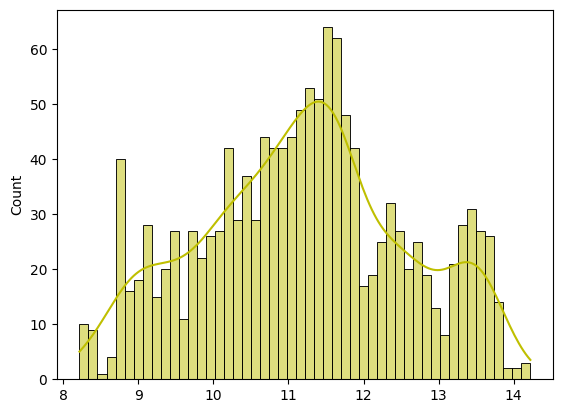

In [ ]:
sns.histplot(y_bc,bins=50,color='y', kde=True)

Veamos si la transformación log se desempeña mejor para este modelo:

<Axes: xlabel='charges', ylabel='Count'>

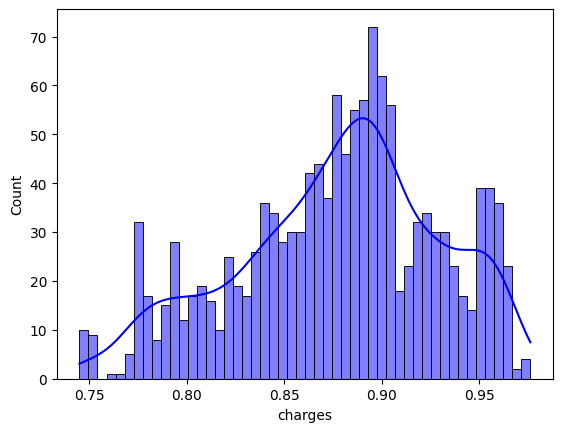

In [ ]:
## Transformación log
df_encode['charges'] = np.log(df_encode['charges'])

a=np.log(df_encode['charges'])
sns.histplot(a, bins=50,color='b', kde=True)

**HACIA EL MODELO**

Luego de esa primera parte que tuvo que ver con acomodar los datos, el siguiente paso es partir el conjunto de datos en: datos para el entrenamiento y datos para el testeo.

Para ello usaremos una función de scikit learn.

In [ ]:
from sklearn.model_selection import train_test_split

X = df_encode.drop('charges',axis=1) # declaramos las variables independientes:
#todas las columnas salvo 'charges'

y = df_encode['charges'] # declaramos la variable dependiente

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=23) # de acuerdo a lo que se
#encuentra/sugiere en la literatura, dividimos el conjunto de datos en 70% para entrenamiento, 30% para testeo.

En este paso de la construcción del modelo, usamos las ecuaciones normales $\mathbf{\theta = (X^T X)^{-1} X^Ty}$ y construimos unos parámetros $\theta$ para el conjunto de datos de entrenamiento.

Antes de eso, necesitamos agregar una feature "ficticia" a nuestro dataset original, la que estará asociada al parámetro $\theta_0$, digamos $\mathbf{x_0 =1}$. Esto implica agregar una columna de todos unos.

In [ ]:
# Paso 1: agregar x0 =1 al dataframe
X_train_0 = np.c_[np.ones((X_train.shape[0],1)),X_train]
X_test_0 = np.c_[np.ones((X_test.shape[0],1)),X_test]

# Paso 2: armamos el modelo
theta = np.matmul(np.linalg.inv( np.matmul(X_train_0.T,X_train_0) ), np.matmul(X_train_0.T,y_train))

In [ ]:
# Los parámetros para el modelo de regresión lineal
parameter = ['theta_'+str(i) for i in range(X_train_0.shape[1])]
columns = ['intersect:x_0=1'] + list(X.columns.values)
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'theta':theta})

Veamos entonces cuáles son los parámetros que obtuvimos con nuestro modelo:

In [ ]:
parameter_df

,Parameter,Columns,theta
0,theta_0,intersect:x_0=1,2.132964
1,theta_1,age,0.004613
2,theta_2,bmi,0.001667
3,theta_3,OHE_male,-0.010130
4,theta_4,OHE_1,0.022533
5,theta_5,OHE_2,0.039444
6,theta_6,OHE_3,0.035449
7,theta_7,OHE_4,0.073358
8,theta_8,OHE_5,0.067819
9,theta_9,OHE_yes,0.202095


El modelo de regresión lineal podemos traerlo directamente desde ScikitLearn. La documentación se encuentra en https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.

Importamos el módulo, instanciamos el modelo y lo entrenamos con nuestros datos:

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

Recuperamos los parámetros que nos devuelve el modelo y los guardamos en una lista:

In [ ]:
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
sk_theta

[2.132964191864605,
 0.004612834087544066,
 0.0016673895340844254,
 -0.010129981556454828,
 0.02253332459137487,
 0.039443975016165075,
 0.03544944415990322,
 0.07335781405625141,
 0.06781902756169236,
 0.2020951911131052,
 -0.007524254194373317,
 -0.020562671860644602,
 -0.01814106081901503]

Comparemos ahora los resultados que obtuvimos con el modelo que hicimos "a mano" y con el del módulo de sklearn. Para esto, agregamos al dataframe de nuestro modelo la columna con las salidas del modelo hecho por sklearn:

In [ ]:
parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
parameter_df

,Parameter,Columns,theta,Sklearn_theta
0,theta_0,intersect:x_0=1,2.132964,2.132964
1,theta_1,age,0.004613,0.004613
2,theta_2,bmi,0.001667,0.001667
3,theta_3,OHE_male,-0.010130,-0.010130
4,theta_4,OHE_1,0.022533,0.022533
5,theta_5,OHE_2,0.039444,0.039444
6,theta_6,OHE_3,0.035449,0.035449
7,theta_7,OHE_4,0.073358,0.073358
8,theta_8,OHE_5,0.067819,0.067819
9,theta_9,OHE_yes,0.202095,0.202095


Los parámetros obtenidos de ambos procedimientos son iguales. Esto quiere decir que si comparamos con el módulo de regresión lineal de Sklearn, hemos construido de manera exitosa nuestro modelo.

¿Qué podemos decir acerca de la "caja negra" LinearRegression de Scikit Learn?

El siguiente paso es la predicción y evaluación del modelo.

## Evaluación del modelo

Vamos a predecir un valor para la variable target usando nuestro modelo, sobre el conjunto de datos test. Luego comparamos el valor predicho con el valor real en el conjunto y_test. Calculamos el **error medio al cuadrado** usando la fórmula:

$$\mathbf{ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}(\hat{y}_i - y_i)^2}.$$

$\mathbf{R^2}$ es una medida estadística para determinar qué tan cerca estamos de la línea de regresión. $\mathbf{R^2}$ será un valor entre $0$ y $100$, donde 0 representa que el modelo no representa la variabilidad del dato respuesta y 100 indica que el modelo explica toda la variabilidad de la respuesta alrededor de la media.


$$\mathbf{R^2 = 1 - \frac{SSE}{SST}}$$
**SSE = Sum of Square Error**  
**SST = Sum of Square Total**  
$$\mathbf{SSE = \sum_{i=1}^{m}(\hat{y}_i - y_i)^2}$$
$$\mathbf{SST = \sum_{i=1}^{m}(y_i - \bar{y}_i)^2}$$
Aquí $\mathbf{\hat{y}}$ es el valor predecido y $\mathbf{\bar{y}}$ es el valor medio de $\mathbf{y}$.

In [ ]:
# Ecuación normal
y_pred_norm =  np.matmul(X_test_0,theta)

# Evaluación: Evaluvation: error medio al cuadrado MSE
J_mse = np.sum((y_pred_norm - y_test)**2)/ X_test_0.shape[0]

# R^2
sse = np.sum((y_pred_norm - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
R_square = 1 - (sse/sst)
print('El error medio al cuadrado (MSE) o valor de J(theta) es:',J_mse)
print('R^2 obtenido para el método de ecuaciones normales es :',R_square)

El error medio al cuadrado (MSE) o valor de J(theta) es: 0.0034995325223184295
R^2 obtenido para el método de ecuaciones normales es : 0.7750325796843252


In [ ]:
# Módulo de regresión lineal de sklearn
y_pred_sk = lin_reg.predict(X_test)

#Evaluación: MSE
from sklearn.metrics import mean_squared_error
J_mse_sk = mean_squared_error(y_pred_sk, y_test)

# R_square
R_square_sk = lin_reg.score(X_test,y_test)
print('El error medio al cuadrado (MSE) o valor de J(theta) es:',J_mse_sk)
print('R^2 obtenido para el método de ecuaciones normales es :',R_square_sk)

El error medio al cuadrado (MSE) o valor de J(theta) es: 0.0006287272273212591
R^2 obtenido para el método de ecuaciones normales es : 0.7711424728456361


El modelo devuelve un valor de 77.95% para $R^2$ lo que quiere decir que se adapta a los datos de manera aceptable, pero aún así podemos mejorar la performance con diferentes técnicas.

Observemos, finalmente, que hemos transformado la variable de salida al aplicar el logaritmo natural. Cuando pongamos al modelo "en producción" deberemos aplicar antilogaritmo a la ecuación.

## Validación del modelo
Para validar el modelo debemos chequear algunos supuestos sobre el modelo de regresión lineal. Las hipótesis básicas para el modelo de *Regresión Lineal son*:

1. Relación lineal: en regresión lineal, la relación entre la variable dependiente y la variable independiente debe ser lineal, ésto puede chequearse con un diagrama de dispersión que compare valor real vs valor predicho.

2. The residual error plot debería estar *normally* distributed.
3. The *mean* of *residual error* debería ser 0 o tan cercano a 0 como sea posible.
4. La regresión lineal requiere que todas las variables tengan una distribución normal multivaluada. Esto se puede checkear con una gráfica Q-Q https://en.wikipedia.org/wiki/Q–Q_plot.
5. La regresión lineal asume que hay muy poca o ninguna *multicolinealidad en los datos*. La multicolinealidad ocurre cuando las variables independientes están muy altamente correlacionadas entre sí. El *variance inflation factor *VIF**  identifica la correlación entre variables independientes y la fuerza de esa correlación:
$$\mathbf{VIF = \frac {1}{1-R^2}},$$
 - VIF >1 & VIF <5 correlación es moderada,
 - VIF > 5 nivel crítico de multicolinealidad.


6. Homosedasticidad: Los datos son homosedásticos significa que los residuales son iguales a lo largo de la recta de regresión. Podemos hacer un gráfico tipo scatter de valores residuales vs. valores entrenados. Una gráfica de datos heterosedásticos debe exhibir un patrón con forma de embudo.


  ![homosedastic.PNG](https://drive.google.com/uc?export=view&id=1hyljs23reE-u6aMiUVlFqpzL-oFvyxtH)

In [ ]:
sns.scatterplot?

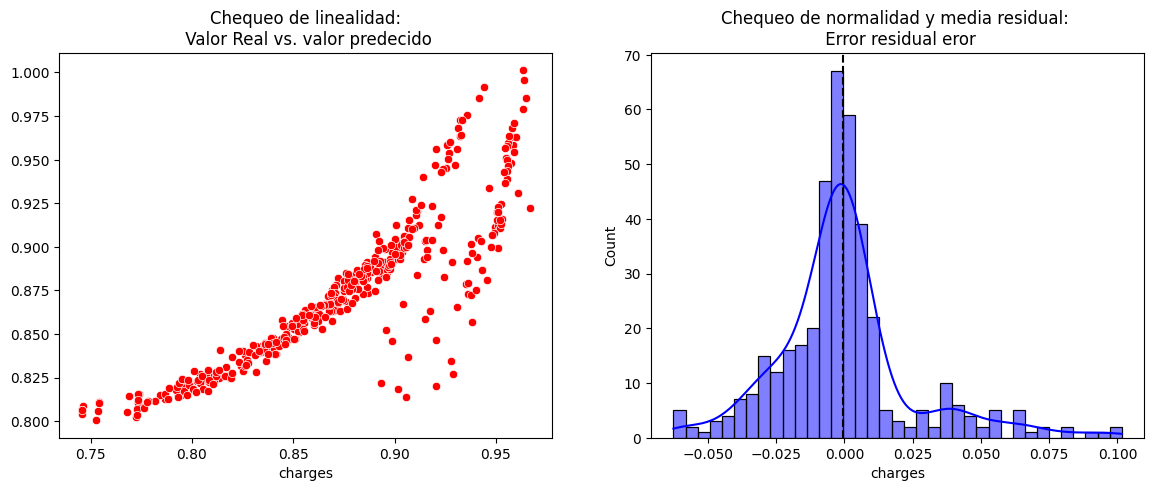

In [ ]:
# Chequeo de linealidad
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(x=y_test,y=y_pred_sk,ax=ax,color='r')
ax.set_title('Chequeo de linealidad:\n Valor Real vs. valor predecido')


# Chequeo de normalidad y media residual
ax = f.add_subplot(122)
sns.histplot((y_test - y_pred_sk),ax=ax,color='b',kde=True)
ax.axvline((y_test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('Chequeo de normalidad y media residual: \n Error residual eror');

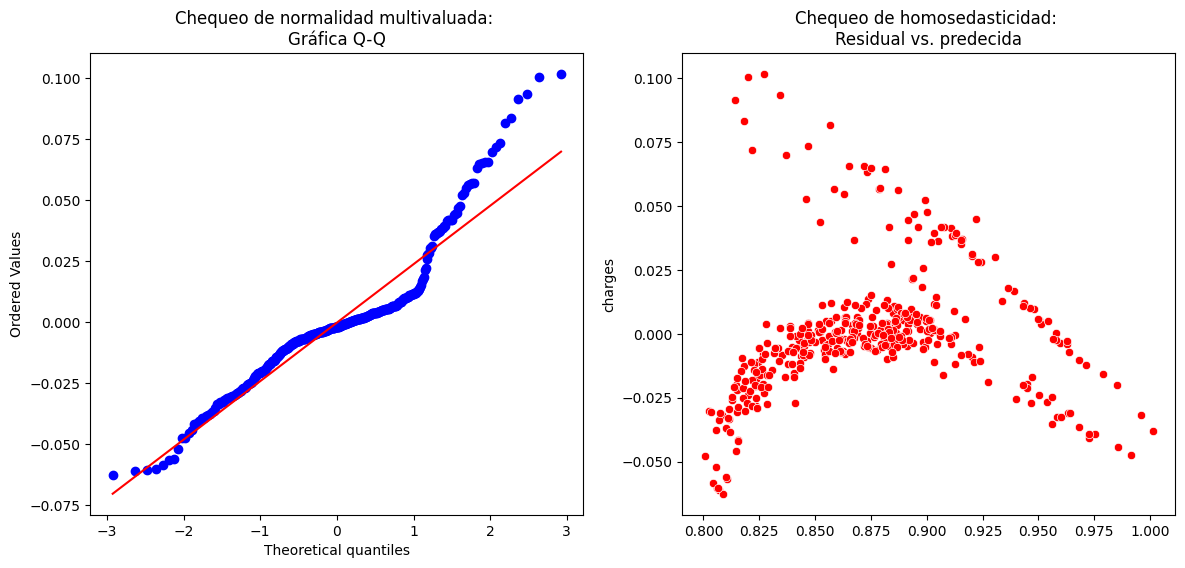

In [ ]:
# Chequeo de normalidad multivaluada
# Gráfica Quantile-Quantile
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y_test - y_pred_sk),fit=True,plot=ax[0])
ax[0].set_title('Chequeo de normalidad multivaluada: \nGráfica Q-Q')

# Chequeo de homosedasticidad
sns.scatterplot(y = (y_test - y_pred_sk), x= y_pred_sk, ax = ax[1],color='r')
ax[1].set_title('Chequeo de homosedasticidad: \nResidual vs. predecida');

In [ ]:
# Chequeo de multicolinealidad
# Variance Inflation Factor
VIF = 1/(1- R_square_sk)
VIF

4.36953074008137

Veamos ahora si las hipótesis de regresión lineal se satisfacen:

1. En nuestro modelo la gráfica de actual vs. predicho es una curva, así que la hipótesis de linealidad falla.

2. La media residual es cero, y la gráfica de error residual está torcida hacia la derecha.

3. La gráfica Q-Q muestra como valor log más grande que 1.5 y tiende a crecer.

4. La gráfica exhibe un comportamiento heterosedastico, el error se va a incrementar luego de cierto punto.

5. El Variance inflation factor value menor a 5, luego no hay multicolinealidad.


1) Siempre va a ocurrir que el método de Scikit Learn arroje los mismos valores para construir el modelo lineal, que los que se obtienen de las ecuaciones normales?

Probemos con distintos datasets...

2) Si así no fuera... qué podemos inferir respecto al módulo Linealregression de Scikit Learn?

3) Cuándo podría pasar que no diera lo mismo?

4) El siguiente código estudia otro dataset y hace una regresión lineal. Proponemos intentar hacer un estudio similar al que hicimos para este dataset, y analizar el código.

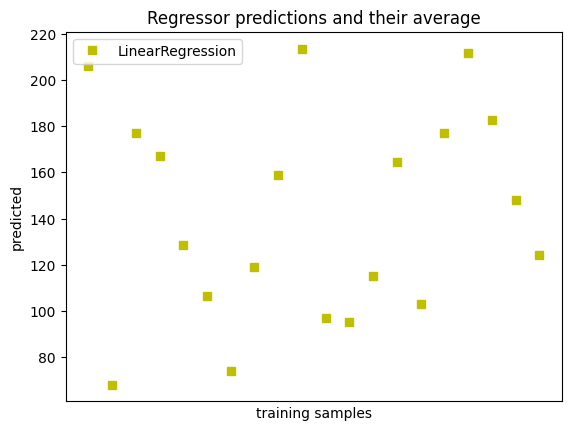

In [ ]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)
reg = LinearRegression()
reg.fit(X, y)
xt = X[:20]
pred = reg.predict(xt)
plt.figure()
plt.plot(pred, "ys", label="LinearRegression")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")
plt.show()


---


Estas notebooks corresponden a la asignatura electiva para la Licenciatura en Matemática del Departamento de Matemática de la Escuela de Cs. Exactas y Naturales, de la Facultad de Cs. Exactas, Ingenieria y Agrimensura (FCEIA) de la Universidad Nacional de Rosario, Argentina. Año 2023.

Fueron confeccionadas a tal fin por las docentes investigadoras de la FCEIA Isolda Cardoso y Jorgelina Walpen. Este trabajo de análisis, estudio, recopilación, traducción, armado, pruebas y errores, nos ha llevado mucho tiempo. Cuando hay tanta información disponible es complicado extraer lo que, al menos para nosotras, es relevante. Hay muchísimos otros recursos y tutoriales, nosotras armamos este.

Si estas notebooks son reproducidas, solicitamos citar la fuente.

Dejamos nuestras páginas laborales y repositorios de GitHub. Seguramente en un futuro las pondremos a disposición en el Repositorio Hipermedial de la UNR.

Isolda: Te dejo mi página laboral https://www.fceia.unr.edu.ar/~isolda/ y mi GitHub https://github.com/IsoldaEugenia. Sentite libre de contactarme.

Jorgelina: https://www.fceia.unr.edu.ar/~walpen/ y  https://github.com/JorWalpen